## Combining PRISM data and shapefiles

In [1]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt 
import jax.numpy as jnp
import numpy as onp
import pyreadr
import pandas as pd
from reusable.geo import get_temp_data, load_state_centroids, centroids_to_coords, get_all_temp_data
import numpyro.diagnostics

In [6]:
def calc_all_centroids():
    all_zctas = gpd.read_file("data/tl_2010_us_zcta510.shp")
    print(all_zctas)
    all_zctas_centroids = gpd.GeoDataFrame(data = all_zctas["ZCTA5CE10"], geometry = all_zctas.geometry.to_crs("EPSG:26914").centroid)

    all_zctas_centroids.to_file("data/zcta_centroids.shp")
    #ny_zctas = all_zctas_centroids.merge(df, how="right", left_on="ZCTA5CE10", right_on="zcta")

def save_state_zctas(state, year):
    file = pyreadr.read_r(f"data/PRISM/ny_tmean/weighted_area_raster_zip_{state}_tmean_daily_{year}.rds")
    df = pd.DataFrame(file[None]["zcta"].unique())
    df.to_pickle(f"data/zctas_state_{state}.pkl")
    return df

def get_state_zctas(state):
    return pd.read_pickle(f"data/zctas_state_{state}.pkl")



def filter_shape_to_state(st, shape="centroids"):
    if shape == "centroids":
        all_centroids = gpd.read_file("data/zcta_centroids.shp")
    elif shape =="boundaries":
        all_centroids = gpd.read_file("data/tl_2010_us_zcta510.shp")
        
    state = get_state_zctas(st)
    filtered = all_centroids.merge(state, how="right", left_on="ZCTA5CE10", right_on=0)
    filtered = filtered.drop(0, axis=1)
    filtered["ZCTA5CE10"] = filtered["ZCTA5CE10"].astype("string")
    print("Saved to " + f"data/state_{st}_{shape}.geojson")
    filtered.to_file(f"data/state_{st}_{shape}.geojson", drive="GeoJSON")
    return filtered

def get_filtered_centroids(st):
    return gpd.read_file(f"data/state_{st}_centroids.geojson")

def save_year_temps(state, year): # creates 1794 entries
    file = pyreadr.read_r(f"data/PRISM/ny_tmean/weighted_area_raster_zip_{state}_tmean_daily_{year}.rds")
    df = pd.DataFrame(file[None])
    df.to_pickle(f"data/state_{state}_{year}_temps.pkl")

def max_yearly_mean_temp(state, year): # creates 1794 entries
    file = pyreadr.read_r(f"data/PRISM/ny_tmean/weighted_area_raster_zip_{state}_tmean_daily_{year}.rds")
    df = pd.DataFrame(file[None])
    df= df[df["tmean"] == df.groupby('zcta')["tmean"].transform("max")]
    df = df.sort_values("zcta")
    df.to_pickle(f"data/state_{state}_{year}_year_max_temps.pkl")
    return df

def mean_mean_temp(state, year): # creates 1794 entries
    df = get_all_temp_data(state, year)
    df = df.groupby('zcta').mean("tmean")
    df = df.sort_values("zcta")
    df.to_pickle(f"data/state_{state}_{year}_mean_temps.pkl")
    return df



# def pair_temps_centroids(st, year, aggr="year_max"):
#     temps_df = get_temp_data(st, year, aggr)
#     centroids = get_filtered_centroids(st)
#     paired = centroids.merge(temps_df, how="right", left_on="ZCTA5CE10", right_on="zcta")
#     paired["ZCTA5CE10"] = paired["ZCTA5CE10"].astype("string")
#     paired["zcta"] = paired["zcta"].astype("string")
#     paired.to_file(f"data/state_{st}_{year}_{aggr}.geojson")
#     return paired
    

def temps_to_r(state, year, aggr="year_max"): # creates 1794 entries
    data = get_temp_data(state, year, aggr)
    data = data.reset_index(drop=True)
    print(data)
    pyreadr.write_rds(f"data/state_{state}_{year}_{aggr}.rds", data)

def centroids_to_r(state):
    centroids = load_state_centroids(state)
    coords = centroids_to_coords(centroids)
    df = pd.DataFrame(coords)
    pyreadr.write_rds(f"data/state_{state}_centroid_coords.rds", df)

def calculate_temps_summary(state, year):
    df = get_all_temp_data(state, year)
    temps = df["tmean"].to_numpy()
    mean = jnp.mean(temps)
    hpdi = numpyro.diagnostics.hpdi(temps - mean, 0.9)
    print(mean, hpdi, numpyro.diagnostics.hpdi(temps, 0.9), jnp.min(temps), jnp.max(temps))

    

In [9]:
mean_mean_temp(36, 1995)

,tmean,year
zcta,,
06390,10.654196,1995.0
10001,12.799652,1995.0
10002,12.810931,1995.0
10003,12.799652,1995.0
10004,12.786672,1995.0
...,...,...
14898,6.935580,1995.0
14901,8.383051,1995.0
14903,8.456973,1995.0


In [10]:
# filter_shape_to_state(36, "boundaries")

KeyboardInterrupt: 

In [22]:
for y in [1994,1995,2009,2010]:
    calculate_temps_summary(36, y)

8.542948 [-17.510138  17.718071] [-8.96718985 26.26101814] -30.834803 30.274391
8.946919 [-16.23156   17.027225] [-7.28464144 25.97414593] -28.557104 32.42541
8.639661 [-16.43953   15.246823] [-7.79986909 23.88648339] -24.818409 29.43985
9.92211 [-16.316704  16.222954] [-6.39459499 26.145063  ] -22.597528 33.681843


       zcta      tmean        date day month    year
0     12041  26.412737  20/06/1995  20    06  1995.0
1     12042  26.782466  20/06/1995  20    06  1995.0
2     12045  28.212657  20/06/1995  20    06  1995.0
3     12054  27.711701  20/06/1995  20    06  1995.0
4     12067  26.799212  20/06/1995  20    06  1995.0
...     ...        ...         ...  ..   ...     ...
1789  13438  25.027048  16/08/1995  16    08  1995.0
1790  13473  24.287195  16/08/1995  16    08  1995.0
1791  13486  25.690282  16/08/1995  16    08  1995.0
1792  13489  24.694198  16/08/1995  16    08  1995.0
1793  13834  26.542061  16/08/1995  16    08  1995.0

[1794 rows x 6 columns]


In [18]:
from reusable.geo import load_state_centroids

g = centroids_to_coords(load_state_centroids(36)["geometry"])
jnp.min(g/100000)

Array(-3.7939124, dtype=float32)

In [9]:
x = get_temp_data(36, 2010)
s= x.sort_values("zcta")
y = get_temp_data(36, 2010)
print(
y["zcta"])
print("sorted")
s

334633    12901
334634    12903
334636    12911
334642    12918
334677    12962
          ...  
437446    14202
437447    14203
437448    14204
437452    14209
437456    14213
Name: zcta, Length: 1794, dtype: category
Categories (1794, object): ['06390', '10001', '10002', '10003', ..., '14901', '14903', '14904', '14905']
sorted


,zcta,tmean,date,day,month,year
335478,06390,29.374929,07/07/2010,07,07,2010.0
335479,10001,33.524719,07/07/2010,07,07,2010.0
335480,10002,32.945292,07/07/2010,07,07,2010.0
335481,10003,33.524719,07/07/2010,07,07,2010.0
335482,10004,32.911363,07/07/2010,07,07,2010.0
...,...,...,...,...,...,...
340855,14898,25.183396,09/07/2010,09,07,2010.0
340856,14901,26.525484,09/07/2010,09,07,2010.0
340857,14903,26.635826,09/07/2010,09,07,2010.0
340858,14904,27.059303,09/07/2010,09,07,2010.0


In [14]:
# filter_shape_to_state(36, "boundaries")
# filter_shape_to_state(36, "centroids")

[max_yearly_mean_temp(36, y) for y in [1994,2009,2010]]

[         zcta      tmean        date day month    year
 362388  06390  26.448005  22/07/1994  22    07  1994.0
 337273  10001  29.974235  08/07/1994  08    07  1994.0
 337274  10002  29.952377  08/07/1994  08    07  1994.0
 337275  10003  29.974235  08/07/1994  08    07  1994.0
 337276  10004  29.963555  08/07/1994  08    07  1994.0
 ...       ...        ...         ...  ..   ...     ...
 304975  14898  24.922404  19/06/1994  19    06  1994.0
 304976  14901  26.498006  19/06/1994  19    06  1994.0
 301389  14903  26.873948  17/06/1994  17    06  1994.0
 304978  14904  27.039669  19/06/1994  19    06  1994.0
 304979  14905  26.843546  19/06/1994  19    06  1994.0
 
 [1794 rows x 6 columns],
          zcta      tmean        date day month    year
 412620  06390  25.357736  19/08/2009  19    08  2009.0
 410827  10001  29.031286  18/08/2009  18    08  2009.0
 398270  10002  28.872586  11/08/2009  11    08  2009.0
 410829  10003  29.031286  18/08/2009  18    08  2009.0
 398272  10004  28.8

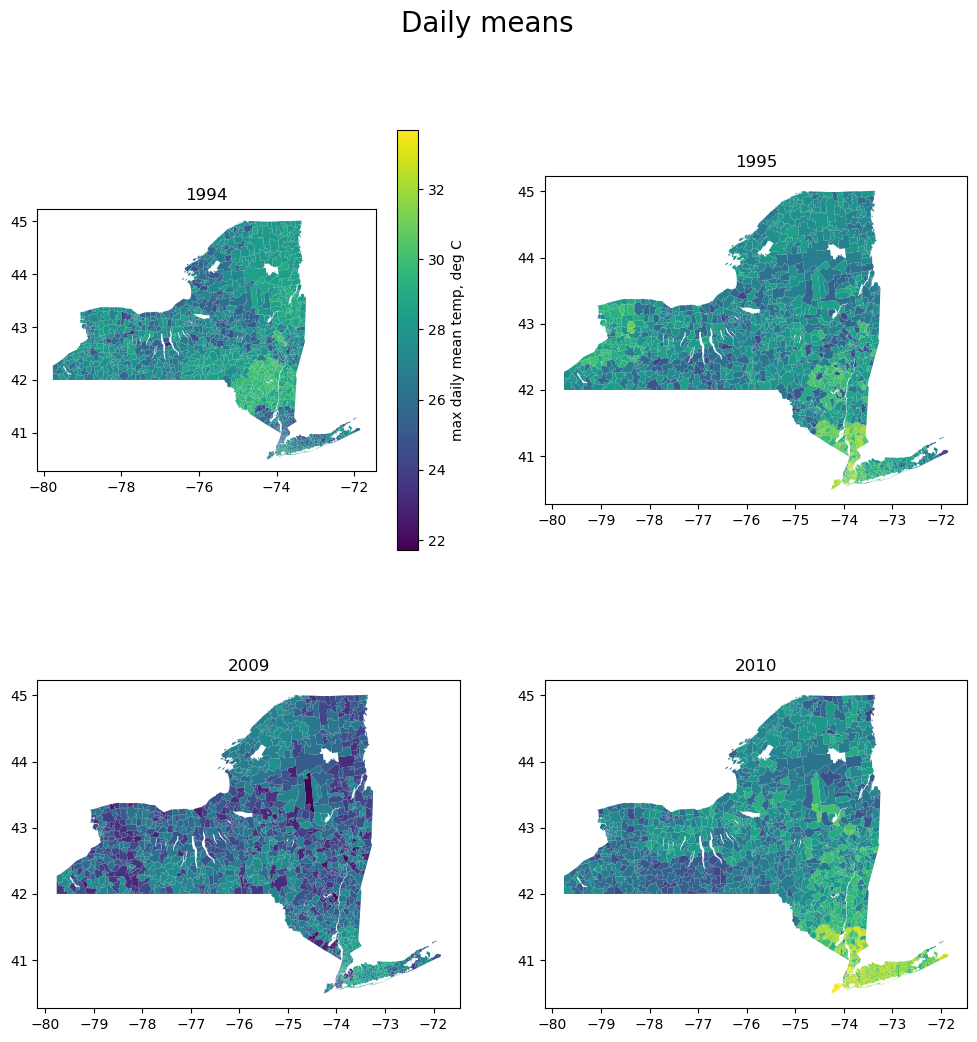

In [13]:
from plotting.ny import plot_on_state, plot_multi_on_state

years= [1994,1995,2009,2010]
data = jnp.array([get_temp_data(36, y)["tmean"].to_numpy() for y in years])
plot_multi_on_state(data, 36, "Daily means", "max daily mean temp, deg C", [str(y) for y in years], num_in_row=2)
#plot_on_state(, 36, f"{y} max daily mean", "temp")